# 02 – LightGBM Base Model (OOF + Test)  
This notebook trains a **LightGBM** fraud classifier using the feature-engineered, time-split datasets produced by:

- `01_preprocessing_real_time_split.ipynb`

It produces:
- `oof_lgb.csv` (out-of-fold probabilities for the **train** period)
- `test_lgb.csv` (probabilities for the **future test** period)

Key requirements implemented:
- **TimeSeriesSplit** (no leakage)
- **Optional SMOTE** inside each fold (train split only)
- **Optuna** hyperparameter tuning to maximize **F2-score** at a fixed threshold
- **Confusion matrix** + metrics on the **test** period
- **SHAP** feature importance plots

> Threshold is set to `0.05` by default (change once at the top and it updates everywhere).

In [1]:
# --- (Optional) Install dependencies (Colab-safe)
# If you're running locally and already have these, you can skip this cell.
try:
    import optuna  # noqa: F401
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "optuna"])

try:
    import shap  # noqa: F401
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "shap"])

# LightGBM / imblearn should already exist in most environments; install if missing.
try:
    import lightgbm  # noqa: F401
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "lightgbm"])

try:
    import imblearn  # noqa: F401
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "imbalanced-learn"])


In [8]:
import os, sys, json, random, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb
import optuna

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    fbeta_score,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    roc_curve,
)

from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")

# -----------------------------
# Global config (EDIT HERE)
# -----------------------------
SEED = 42
N_SPLITS = 5            # TimeSeriesSplit folds for OOF + Optuna CV
N_TRIALS = 2           # Optuna trials (increase for better tuning)
THRESHOLD = 0.05        # Fixed threshold for all models (change any time)
USE_SMOTE = True        # SMOTE only applied inside each training fold
SMOTE_SAMPLING = 0.15   # Only used when USE_SMOTE=True (fraud ratio after SMOTE)

np.random.seed(SEED)
random.seed(SEED)

# Detect Colab + mount Drive
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    from google.colab import drive  # type: ignore
    drive.mount("/content/drive")

# Adjust if needed
datapath = "/content/drive/MyDrive/RThesis/" if IN_COLAB else "./"
os.makedirs(datapath, exist_ok=True)

print("datapath =", datapath)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
datapath = /content/drive/MyDrive/RThesis/


In [3]:
# -----------------------------
# Load preprocessed datasets
# -----------------------------
X_train_path = os.path.join(datapath, "X_train_lgb.csv")
X_test_path  = os.path.join(datapath, "X_test_lgb.csv")
y_train_path = os.path.join(datapath, "y_train.csv")
y_test_path  = os.path.join(datapath, "y_test.csv")
train_keys_path = os.path.join(datapath, "train_keys.csv")
test_keys_path  = os.path.join(datapath, "test_keys.csv")

for p in [X_train_path, X_test_path, y_train_path, y_test_path, train_keys_path, test_keys_path]:
    assert os.path.exists(p), f"Missing file: {p}"

X_train = pd.read_csv(X_train_path)
X_test  = pd.read_csv(X_test_path)

y_train_df = pd.read_csv(y_train_path)
y_test_df  = pd.read_csv(y_test_path)
y_train = y_train_df["isFraud"].astype(int)
y_test  = y_test_df["isFraud"].astype(int)

train_keys = pd.read_csv(train_keys_path)
test_keys  = pd.read_csv(test_keys_path)

# row_id alignment
if "row_id" in train_keys.columns:
    row_id_train = train_keys["row_id"].values
else:
    row_id_train = np.arange(len(X_train))

if "row_id" in test_keys.columns:
    row_id_test = test_keys["row_id"].values
else:
    row_id_test = np.arange(len(X_test))

assert len(X_train) == len(y_train) == len(row_id_train), "Train alignment mismatch"
assert len(X_test)  == len(y_test)  == len(row_id_test), "Test alignment mismatch"

print("X_train:", X_train.shape, " | fraud rate:", y_train.mean())
print("X_test :", X_test.shape,  " | fraud rate:", y_test.mean())


X_train: (472432, 38)  | fraud rate: 0.03513521522674162
X_test : (118108, 38)  | fraud rate: 0.034409184813899145


In [4]:
# -----------------------------
# Basic preprocessing for LightGBM:
# - Ordinal-encode object / category columns
# (preprocessing notebook keeps a few categorical columns as strings)
# -----------------------------
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()
print("Categorical columns detected:", cat_cols)

enc = None
X_train_enc = X_train.copy()
X_test_enc  = X_test.copy()

if len(cat_cols) > 0:
    enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    X_train_enc[cat_cols] = enc.fit_transform(X_train[cat_cols])
    X_test_enc[cat_cols]  = enc.transform(X_test[cat_cols])

# Ensure all are numeric
for c in X_train_enc.columns:
    if X_train_enc[c].dtype == "bool":
        X_train_enc[c] = X_train_enc[c].astype(int)
        X_test_enc[c]  = X_test_enc[c].astype(int)

# Defensive conversion (rare object leftovers)
X_train_enc = X_train_enc.apply(pd.to_numeric, errors="coerce").fillna(0)
X_test_enc  = X_test_enc.apply(pd.to_numeric, errors="coerce").fillna(0)

print("Encoded dtypes ok:", X_train_enc.dtypes.unique())


Categorical columns detected: ['ProductCD', 'card4', 'card6']
Encoded dtypes ok: [dtype('float64') dtype('int64')]


In [5]:
# -----------------------------
# Helper functions
# -----------------------------
def compute_f2(y_true, y_score, threshold=THRESHOLD, beta=2.0):
    y_pred = (y_score >= threshold).astype(int)
    return fbeta_score(y_true, y_pred, beta=beta, zero_division=0)

def evaluate_binary(y_true, y_score, threshold=THRESHOLD, title="Model"):
    y_pred = (y_score >= threshold).astype(int)

    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f2   = fbeta_score(y_true, y_pred, beta=2.0, zero_division=0)

    try:
        auc = roc_auc_score(y_true, y_score)
    except Exception:
        auc = np.nan
    try:
        ap = average_precision_score(y_true, y_score)
    except Exception:
        ap = np.nan

    print(f"\n[{title}]  threshold={threshold}")
    print(f"Precision: {prec:.4f} | Recall: {rec:.4f} | F2: {f2:.4f} | ROC-AUC: {auc:.4f} | PR-AUC: {ap:.4f}")
    print("\nClassification report:")
    print(classification_report(y_true, y_pred, digits=4, zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion matrix:\n", cm)

    # Plot CM
    fig, ax = plt.subplots()
    im = ax.imshow(cm)
    ax.set_title(f"{title} – Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["Non-Fraud","Fraud"])
    ax.set_yticklabels(["Non-Fraud","Fraud"])
    for (i, j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center")
    plt.show()

    # ROC + PR curves
    try:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        plt.figure()
        plt.plot(fpr, tpr)
        plt.plot([0,1],[0,1], linestyle="--")
        plt.title(f"{title} – ROC Curve")
        plt.xlabel("FPR"); plt.ylabel("TPR")
        plt.show()
    except Exception as e:
        print("ROC curve skipped:", e)

    try:
        p, r, _ = precision_recall_curve(y_true, y_score)
        plt.figure()
        plt.plot(r, p)
        plt.title(f"{title} – Precision-Recall Curve")
        plt.xlabel("Recall"); plt.ylabel("Precision")
        plt.show()
    except Exception as e:
        print("PR curve skipped:", e)

    return {"precision": prec, "recall": rec, "f2": f2, "roc_auc": auc, "pr_auc": ap, "cm": cm}

def fit_lgbm_fold(X_tr, y_tr, X_va, y_va, params, use_smote=USE_SMOTE):
    # Optional SMOTE (train fold only)
    if use_smote:
        n_pos = int(pd.Series(y_tr).sum())
        if n_pos >= 2:
            k = min(5, n_pos - 1)
            sm = SMOTE(sampling_strategy=SMOTE_SAMPLING, random_state=SEED, k_neighbors=k)
            X_res, y_res = sm.fit_resample(X_tr, y_tr)
        else:
            # Not enough positives to run SMOTE
            X_res, y_res = X_tr, y_tr
    else:
        X_res, y_res = X_tr, y_tr

    model = lgb.LGBMClassifier(**params)
    callbacks = [lgb.early_stopping(stopping_rounds=200, verbose=False)]
    model.fit(
        X_res, y_res,
        eval_set=[(X_va, y_va)],
        eval_metric="average_precision",  # PR-AUC helps with imbalance
        callbacks=callbacks
    )
    proba_va = model.predict_proba(X_va)[:, list(model.classes_).index(1)]
    return model, proba_va


In [9]:
# -----------------------------
# Optuna hyperparameter tuning (maximize mean CV F2)
# -----------------------------
n_pos = int(y_train.sum())
n_neg = int((1 - y_train).sum())
base_spw = max(1.0, n_neg / max(1, n_pos))

def make_params(trial):
    return {
        "objective": "binary",
        "random_state": SEED,
        "n_jobs": -1,

        # Core
        "n_estimators": trial.suggest_int("n_estimators", 400, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 31, 256, log=True),
        "max_depth": trial.suggest_int("max_depth", -1, 12),

        # Regularization + sampling
        "min_child_samples": trial.suggest_int("min_child_samples", 20, 300),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),

        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),

        # Imbalance
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.5 * base_spw, 2.0 * base_spw, log=True),

        # Stability
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 0.5),
    }

def objective(trial):
    tss = TimeSeriesSplit(n_splits=N_SPLITS)
    f2s = []

    params = make_params(trial)

    for fold, (tr_idx, va_idx) in enumerate(tss.split(X_train_enc)):
        X_tr, y_tr = X_train_enc.iloc[tr_idx], y_train.iloc[tr_idx]
        X_va, y_va = X_train_enc.iloc[va_idx], y_train.iloc[va_idx]

        _, proba_va = fit_lgbm_fold(X_tr, y_tr, X_va, y_va, params, use_smote=USE_SMOTE)
        f2s.append(compute_f2(y_va.values, proba_va, threshold=THRESHOLD))

    return float(np.mean(f2s))

study = optuna.create_study(direction="maximize", study_name="lgb_f2")
study.optimize(objective, n_trials=N_TRIALS)

best_params = study.best_trial.params
print("Best CV F2:", study.best_value)
print("Best params:\n", json.dumps(best_params, indent=2))


[I 2025-12-27 17:51:36,545] A new study created in memory with name: lgb_f2


[LightGBM] [Info] Number of positive: 11496, number of negative: 76642
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6817
[LightGBM] [Info] Number of data points in the train set: 88138, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130432 -> initscore=-1.897146
[LightGBM] [Info] Start training from score -1.897146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2025-12-27 17:53:11,525] Trial 0 finished with value: 0.19370699424786358 and parameters: {'n_estimators': 2618, 'learning_rate': 0.0925373200659307, 'num_leaves': 140, 'max_depth': 6, 'min_child_samples': 140, 'subsample': 0.8900943713834738, 'colsample_bytree': 0.772356832724357, 'reg_alpha': 0.2102500048424061, 'reg_lambda': 4.6306149046245136e-08, 'scale_pos_weight': 24.213473754732973, 'min_split_gain': 0.2521990830724847}. Best is trial 0 with value: 0.19370699424786358.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 11496, number of negative: 76642
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012149 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6817
[LightGBM] [Info] Number of data points in the train set: 88138, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130432 -> initscore=-1.897146
[LightGBM] [Info] Start training from score -1.897146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2025-12-27 17:55:30,323] Trial 1 finished with value: 0.22957996214354354 and parameters: {'n_estimators': 780, 'learning_rate': 0.06222793694736778, 'num_leaves': 171, 'max_depth': 12, 'min_child_samples': 118, 'subsample': 0.9005146155334873, 'colsample_bytree': 0.9471122644839396, 'reg_alpha': 0.7992681399472696, 'reg_lambda': 0.05034194375271075, 'scale_pos_weight': 30.31322451217701, 'min_split_gain': 0.27865394382184017}. Best is trial 1 with value: 0.22957996214354354.


Best CV F2: 0.22957996214354354
Best params:
 {
  "n_estimators": 780,
  "learning_rate": 0.06222793694736778,
  "num_leaves": 171,
  "max_depth": 12,
  "min_child_samples": 118,
  "subsample": 0.9005146155334873,
  "colsample_bytree": 0.9471122644839396,
  "reg_alpha": 0.7992681399472696,
  "reg_lambda": 0.05034194375271075,
  "scale_pos_weight": 30.31322451217701,
  "min_split_gain": 0.27865394382184017
}


In [10]:
# -----------------------------
# Build final params dict (merge fixed + best params)
# -----------------------------
final_params = {
    "objective": "binary",
    "random_state": SEED,
    "n_jobs": -1,
    **best_params
}

# Persist best params for reproducibility
best_params_path = os.path.join(datapath, "best_params_lgb.json")
with open(best_params_path, "w") as f:
    json.dump(final_params, f, indent=2)
print("Saved best params to:", best_params_path)


Saved best params to: /content/drive/MyDrive/RThesis/best_params_lgb.json


[LightGBM] [Info] Number of positive: 11496, number of negative: 76642
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6817
[LightGBM] [Info] Number of data points in the train set: 88138, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130432 -> initscore=-1.897146
[LightGBM] [Info] Start training from score -1.897146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

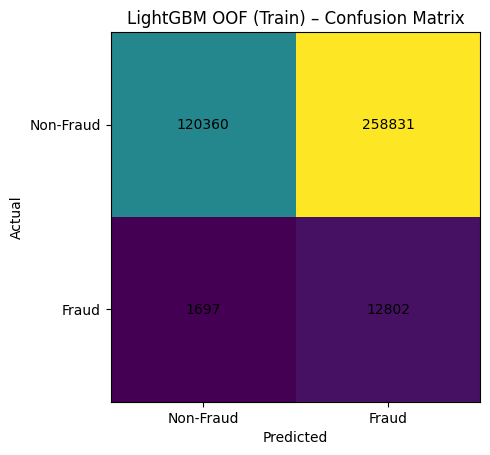

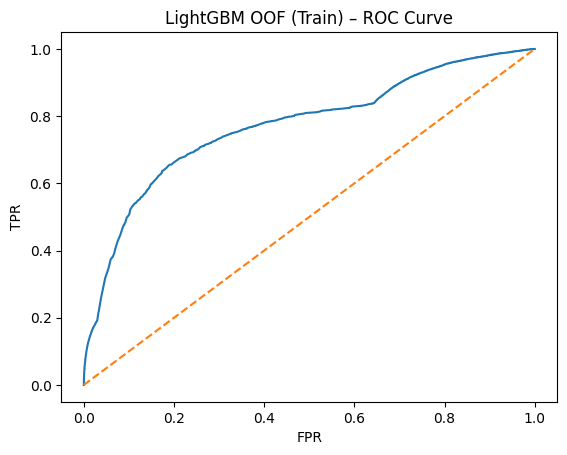

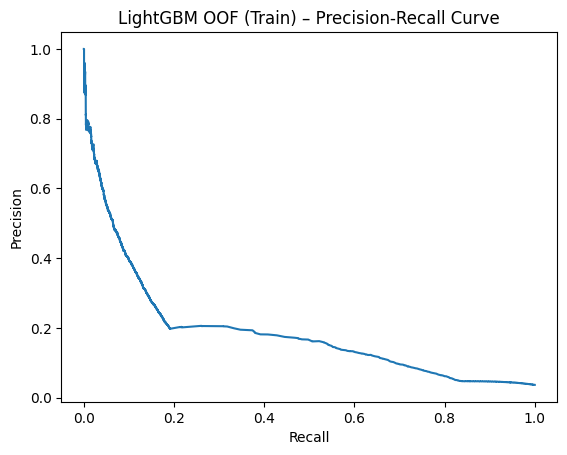

OOF coverage: 0.8333262776441901 (fraction of train rows used for meta)


In [11]:
# -----------------------------
# Generate OOF predictions with best params (TimeSeriesSplit)
# Note: TimeSeriesSplit does NOT give OOF for the very first chunk.
# Those rows remain NaN and are excluded from meta training (no leakage).
# -----------------------------
tss = TimeSeriesSplit(n_splits=N_SPLITS)

oof_proba = np.full(len(X_train_enc), np.nan, dtype=float)
oof_fold = np.full(len(X_train_enc), -1, dtype=int)
has_oof = np.zeros(len(X_train_enc), dtype=bool)

for fold, (tr_idx, va_idx) in enumerate(tss.split(X_train_enc), start=1):
    X_tr, y_tr = X_train_enc.iloc[tr_idx], y_train.iloc[tr_idx]
    X_va, y_va = X_train_enc.iloc[va_idx], y_train.iloc[va_idx]

    model, proba_va = fit_lgbm_fold(X_tr, y_tr, X_va, y_va, final_params, use_smote=USE_SMOTE)
    oof_proba[va_idx] = proba_va
    oof_fold[va_idx] = fold
    has_oof[va_idx] = True

    f2_fold = compute_f2(y_va.values, proba_va, threshold=THRESHOLD)
    print(f"Fold {fold}/{N_SPLITS} F2={f2_fold:.4f}")

# Evaluate OOF only where we actually have OOF predictions
mask = has_oof
_ = evaluate_binary(y_train.values[mask], oof_proba[mask], threshold=THRESHOLD, title="LightGBM OOF (Train)")
print("OOF coverage:", mask.mean(), "(fraction of train rows used for meta)")


In [12]:
# -----------------------------
# Train final model on FULL train (time-aware early stopping -> refit)
# -----------------------------
# Use last 10% of train as internal validation to find best_iteration
split = int(len(X_train_enc) * 0.90)
X_tr0, y_tr0 = X_train_enc.iloc[:split], y_train.iloc[:split]
X_va0, y_va0 = X_train_enc.iloc[split:], y_train.iloc[split:]

# SMOTE only on the earlier 90% (avoid peeking into last 10%)
if USE_SMOTE:
    n_pos = int(y_tr0.sum())
    if n_pos >= 2:
        k = min(5, n_pos - 1)
        sm = SMOTE(sampling_strategy=SMOTE_SAMPLING, random_state=SEED, k_neighbors=k)
        X_tr0_res, y_tr0_res = sm.fit_resample(X_tr0, y_tr0)
    else:
        X_tr0_res, y_tr0_res = X_tr0, y_tr0
else:
    X_tr0_res, y_tr0_res = X_tr0, y_tr0

tmp_model = lgb.LGBMClassifier(**final_params)
tmp_model.fit(
    X_tr0_res, y_tr0_res,
    eval_set=[(X_va0, y_va0)],
    eval_metric="average_precision",
    callbacks=[lgb.early_stopping(300, verbose=False)]
)

best_iter = getattr(tmp_model, "best_iteration_", None)
print("Best iteration from internal validation:", best_iter)

# Refit on ALL train using best_iter (if available)
refit_params = dict(final_params)
if best_iter is not None and best_iter > 0:
    refit_params["n_estimators"] = int(best_iter)

if USE_SMOTE:
    n_pos = int(y_train.sum())
    if n_pos >= 2:
        k = min(5, n_pos - 1)
        sm = SMOTE(sampling_strategy=SMOTE_SAMPLING, random_state=SEED, k_neighbors=k)
        X_res_full, y_res_full = sm.fit_resample(X_train_enc, y_train)
    else:
        X_res_full, y_res_full = X_train_enc, y_train
else:
    X_res_full, y_res_full = X_train_enc, y_train

final_model = lgb.LGBMClassifier(**refit_params)
final_model.fit(X_res_full, y_res_full)

print("Final model fitted.")


[LightGBM] [Info] Number of positive: 61536, number of negative: 410243
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.161737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6992
[LightGBM] [Info] Number of data points in the train set: 471779, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.130434 -> initscore=-1.897127
[LightGBM] [Info] Start training from score -1.897127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g


[LightGBM (Test)]  threshold=0.05
Precision: 0.1112 | Recall: 0.7463 | F2: 0.3484 | ROC-AUC: 0.8505 | PR-AUC: 0.2729

Classification report:
              precision    recall  f1-score   support

           0     0.9886    0.7874    0.8766    114044
           1     0.1112    0.7463    0.1936      4064

    accuracy                         0.7860    118108
   macro avg     0.5499    0.7669    0.5351    118108
weighted avg     0.9585    0.7860    0.8531    118108

Confusion matrix:
 [[89803 24241]
 [ 1031  3033]]


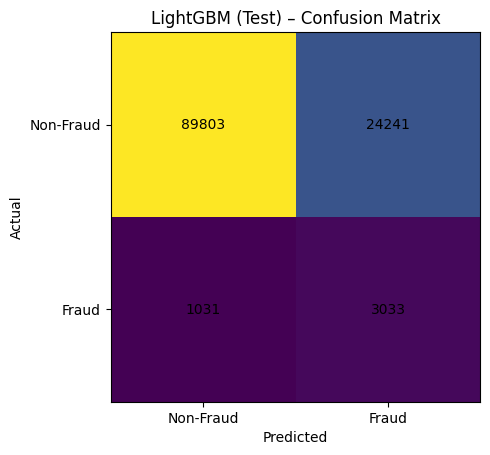

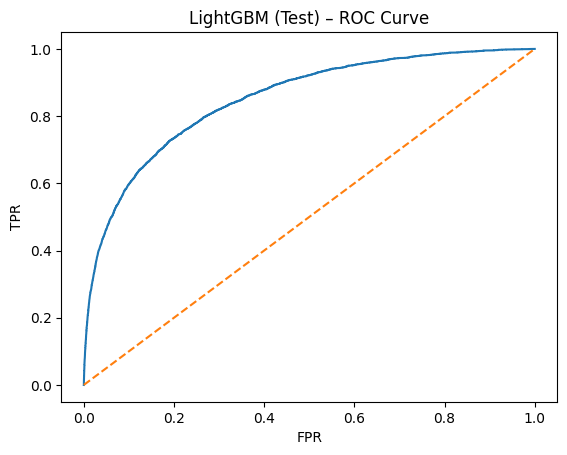

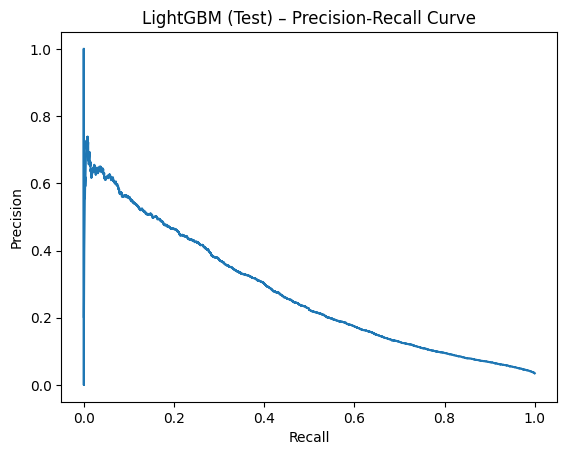

Saved: /content/drive/MyDrive/RThesis/oof_lgb.csv
Saved: /content/drive/MyDrive/RThesis/test_lgb.csv


In [13]:
# -----------------------------
# Test predictions + evaluation
# -----------------------------
test_proba = final_model.predict_proba(X_test_enc)[:, list(final_model.classes_).index(1)]

_ = evaluate_binary(y_test.values, test_proba, threshold=THRESHOLD, title="LightGBM (Test)")

# Save OOF + Test predictions
oof_df = pd.DataFrame({
    "row_id": row_id_train,
    "y_true": y_train.values,
    "has_oof": has_oof,
    "fold": oof_fold,
    "lgb_proba": oof_proba,
    "pred_label": np.where(has_oof, (oof_proba >= THRESHOLD).astype(int), np.nan),
    "threshold_used": np.where(has_oof, THRESHOLD, np.nan),
})

test_df = pd.DataFrame({
    "row_id": row_id_test,
    "y_true": y_test.values,
    "lgb_proba": test_proba,
    "pred_label": (test_proba >= THRESHOLD).astype(int),
    "threshold_used": THRESHOLD,
})

oof_path  = os.path.join(datapath, "oof_lgb.csv")
test_path = os.path.join(datapath, "test_lgb.csv")
oof_df.to_csv(oof_path, index=False)
test_df.to_csv(test_path, index=False)

print("Saved:", oof_path)
print("Saved:", test_path)


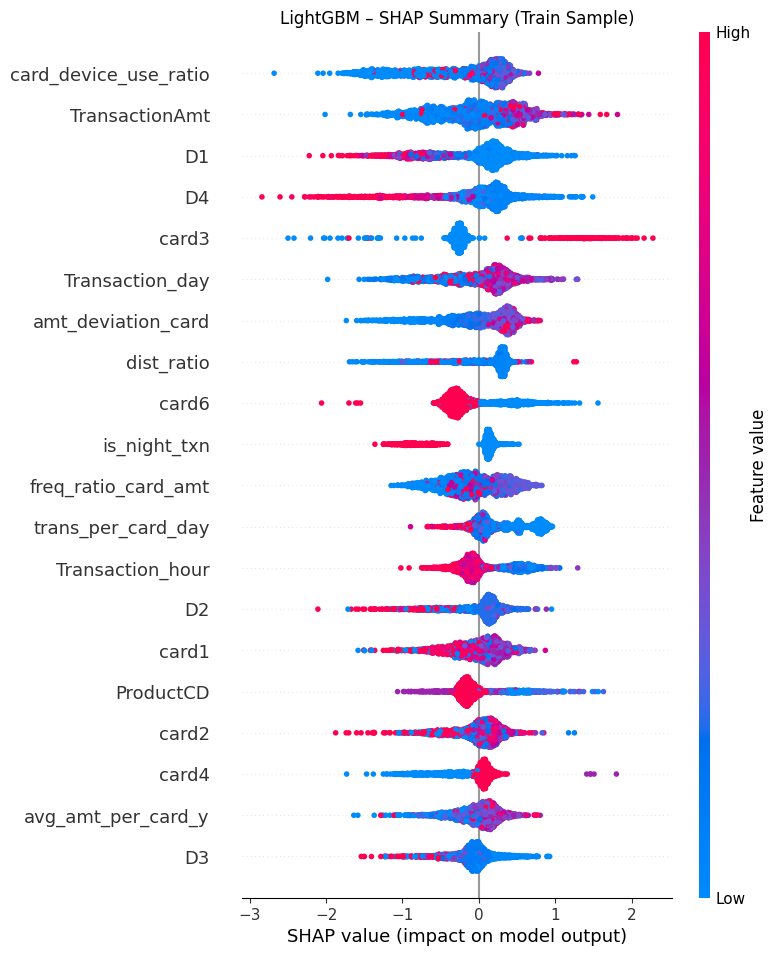

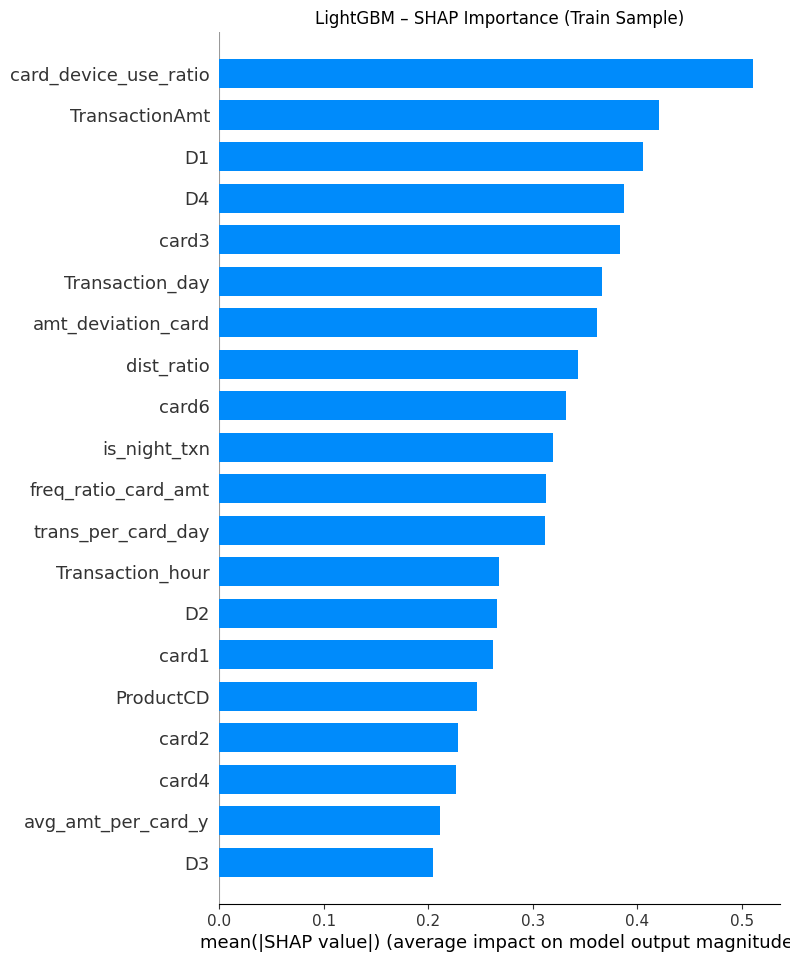

In [14]:
# -----------------------------
# SHAP (LightGBM) – feature attribution
# -----------------------------
import shap

# Use a manageable sample for SHAP
SAMPLE_SIZE = min(2000, len(X_train_enc))
shap_sample = X_train_enc.sample(n=SAMPLE_SIZE, random_state=SEED)

# TreeExplainer prefers the underlying Booster
booster = final_model.booster_ if hasattr(final_model, "booster_") else final_model

explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(shap_sample)

# For binary classification shap_values can be list [neg, pos] or a single array
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_vals_to_plot = shap_values[1]
else:
    shap_vals_to_plot = shap_values

# Summary plot (beeswarm)
shap.summary_plot(shap_vals_to_plot, shap_sample, show=False)
plt.title("LightGBM – SHAP Summary (Train Sample)")
plt.show()

# Bar plot (global importance)
shap.summary_plot(shap_vals_to_plot, shap_sample, plot_type="bar", show=False)
plt.title("LightGBM – SHAP Importance (Train Sample)")
plt.show()
